In [2]:
import ssam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import anndata as ad

In [3]:
ds = ssam.SSAMDataset("data/processed/ssamdataset-osmFISH.zarr")
analysis = ssam.SSAMAnalysis(ds, ncores=40, verbose=True)

Loaded existing KDE results.
Loaded existing local maxima.
Loaded a precomputed normalized vector field.
Loaded existing cluster labels.
Loaded an existing t-SNE result.
Loaded an existing UMAP result.
Loaded existing cell type maps.
Loaded existing filtered cell type maps.
Loaded existing cell type binned centers and counts.


Loaded existing inferred domains.
Loaded existing watershed segmentations.
Loaded existing transferred cluster labels.


In [ ]:
table_list = []
for lib in libraries:
    table = ad.read(path_read / f"{lib}_table.h5ad")
    table.obs["library_id"] = f"{lib}_labels"
    table_list.append(table)

table = ad.concat(
    table_list,
    keys=libraries,
)
table = TableModel.parse(
    adata=table,
    region=[f"{lib}_labels" for lib in libraries],
    region_key="library_id",
    instance_key="cell_id",
)

In [13]:
ds.celltype_maps.shape

(1640, 3368, 1)

In [14]:
ds.genes

['Acta2',
 'Aldoc',
 'Anln',
 'Apln',
 'Bmp4',
 'Cnr1',
 'Cpne5',
 'Crh',
 'Crhbp',
 'Ctps',
 'Flt1',
 'Foxj1',
 'Gad2',
 'Gfap',
 'Hexb',
 'Itpr2',
 'Kcnip2',
 'Lamp5',
 'Mfge8',
 'Mrc1',
 'Pdgfra',
 'Plp1',
 'Pthlh',
 'Rorb',
 'Serpinf1',
 'Slc32a1',
 'Sox10',
 'Syt6',
 'Tbr1',
 'Tmem2',
 'Ttr',
 'Vip',
 'Vtn']

In [15]:
ds.normalized_vectors[ds.filtered_cluster_labels == idx]

NameError: name 'idx' is not defined

In [4]:
np.unique(ds.watershed_segments)

array([  -1,    0,    1, ..., 8052, 8053, 8054])

In [5]:
np.unique(ds.celltype_maps)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [6]:
ds.celltype_maps.shape

(1640, 3368, 1)

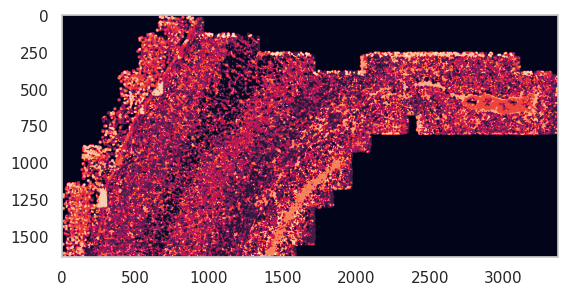

In [4]:
plt.imshow(ds.celltype_maps)

In [12]:
ds.normalized_vectors

array([[1.5157988e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0327135e+00, 0.0000000e+00],
       [2.1139686e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.6181903e-01, 0.0000000e+00],
       [1.1881777e+00, 0.0000000e+00, 3.6503128e-03, ..., 1.8249776e-03,
        2.0121345e-03, 1.7225202e-03],
       ...,
       [0.0000000e+00, 4.0172719e-05, 2.8322864e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.9869366e-01, 1.3585980e-01, ..., 0.0000000e+00,
        6.0198883e-05, 0.0000000e+00],
       [0.0000000e+00, 6.4316567e-04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [8]:
np.squeeze(ds.celltype_maps,2).shape

(1640, 3368)

In [11]:
len(np.squeeze(ds.celltype_maps,2)[0])

3368

In [ ]:
len(ds.filtered_cluster_labels)

In [12]:
np.unique(ds.filtered_cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [14]:
ds.normalized_vectors.shape

(11443, 33)

In [22]:
len(ds.genes)

33

In [110]:
np.unique(ds.filtered_cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [40]:
ds.normalized_vectors.shape

(11443, 33)

In [65]:
len(ds.normalized_vectors[ds.filtered_cluster_labels == 0])

505

In [20]:
#33: gene 갯수
#백터
for i in range(len(np.unique(ds.filtered_cluster_labels))):
    print(ds.normalized_vectors[ds.filtered_cluster_labels == i].shape)

(505, 33)
(263, 33)
(341, 33)
(316, 33)
(274, 33)
(86, 33)
(60, 33)
(230, 33)
(50, 33)
(249, 33)
(206, 33)
(120, 33)
(122, 33)
(15, 33)
(155, 33)
(116, 33)
(141, 33)
(170, 33)
(171, 33)
(59, 33)
(154, 33)
(85, 33)
(75, 33)
(102, 33)
(127, 33)
(84, 33)
(24, 33)
(59, 33)
(92, 33)
(57, 33)
(43, 33)
(58, 33)
(98, 33)
(20, 33)
(54, 33)
(18, 33)
(27, 33)
(16, 33)
(23, 33)
(0, 33)


In [8]:
import h5py

pixel_per_um = 15.3846 # from BioRxiv paper
um_per_pixel = 1.0 / pixel_per_um

blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

with h5py.File("./data/raw/mRNA_coords_raw_counting.hdf5", 'r') as f:
    # Extract gene names (keys)
    gene_names = list(f.keys())
    # Extract x, y coordinates for each gene and store them along with the gene name
    data_list = []
    for gene in gene_names:
        if gene in blacklists:
            continue
        xx, yy = f[gene][:].T
        gene = gene.split("_")[0]
        
        if gene == 'Tmem6':
            gene = 'Tmem2'
        elif gene == 'Kcnip':
            gene = 'Kcnip2'

        for x, y in zip(xx, yy):
            data_list.append([gene, x * um_per_pixel, y * um_per_pixel])

# Create a pandas DataFrame
df = pd.DataFrame(data_list, columns=['gene', 'x', 'y']).set_index('gene')

In [9]:
analysis.compute_cell_by_gene_matrix(df)

Generating spatial mRNA count matrix...


Computing cell-by-gene matrix...


In [75]:
cell_by_gene_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0, 12,  0, ...,  0,  0,  0],
       ...,
       [ 0, 11,  2, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 1,  4,  1, ...,  1,  2,  1]])

In [109]:
np.unique(ds.celltype_maps)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [82]:
table_1.obs['cell_id']

0         -1
1          0
2          1
3          2
4          3
        ... 
8051    8050
8052    8051
8053    8052
8054    8053
8055    8054
Name: cell_id, Length: 8056, dtype: int64

In [79]:
np.arange(-1, len(ds.cell_by_gene_matrix), 1)

array([  -1,    0,    1, ..., 8052, 8053, 8054])

In [52]:
np.unique(ds.watershed_segments)

array([  -1,    0,    1, ..., 8052, 8053, 8054])

In [34]:
#cell_id 열과 region 값 일치 확인: AnnData 객체의 obs 데이터에 있는 cell_id 열의 값이 region 값과 일치하는지 확인하십시오. cell_id 열은 각 세포 또는 데이터 포인트를 고유하게 식별하는 데 사용되며, region 값은 각 세포 또는 데이터 포인트가 속한 지역을 나타냅니다. 두 열 간의 일치가 중요합니다.
len(ds.watershed_segments)

1640

In [ ]:
# ds.celltype_binned_counts had shape (x, y, 1, c), but we need (c, y, x)
celltype_binned_counts = sd.models.Image2DModel.parse(np.squeeze(ds.celltype_binned_counts, 2), dims=('y', 'x', 'c'))

# ds.celltype_binned_centers had shape (x, y, 1), but we need (y, x)
celltype_binned_centers = sd.models.Labels2DModel.parse(np.squeeze(ds.celltype_binned_centers, 2), dims=('y', 'x'))
celltype_maps = sd.models.Labels2DModel.parse(np.squeeze(ds.celltype_maps+1, 2), dims=('y', 'x'))
filtered_celltype_maps = sd.models.Labels2DModel.parse(np.squeeze(ds.filtered_celltype_maps+1, 2), dims=('y', 'x'))
inferred_domains = sd.models.Labels2DModel.parse(np.squeeze(ds.inferred_domains+1, 2), dims=('y', 'x'))
inferred_domains_cells = sd.models.Labels2DModel.parse(np.squeeze(ds.inferred_domains_cells+1, 2), dims=('y', 'x'))

#)

In [12]:
new_element = [0 for i in range(len(ds.genes))]
cell_by_gene_matrix = np.insert(ds.cell_by_gene_matrix, 0, new_element, axis=0)

In [13]:
import scanpy as sc
table_1 = sc.AnnData(cell_by_gene_matrix)

table_1.var_names = ds.genes
table_1.obs["region"] = "cells"
table_1.obs['cell_id'] = np.arange(len(cell_by_gene_matrix))

expression = sd.models.TableModel.parse(
    adata=table_1,
    region="cells",
    region_key='region',
    instance_key="cell_id",
)

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/models/models.py:725: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[region_key]):
/tmp/ipykernel_793046/998446211.py:8: UserWarning: Converting `region_key: region` to categorical dtype.
  expression = sd.models.TableModel.parse(


In [14]:
import spatialdata as sd
import numpy as np
import scanpy as sc

watershed_segments = sd.models.Labels2DModel.parse(ds.watershed_segments+1, dims=('y', 'x'))
celltype_maps = sd.models.Image2DModel.parse(ds.celltype_maps, dims=('y', 'x', 'c'))

sdata = sd.SpatialData(images = {'celltype_maps': celltype_maps},labels={'watershed_segments': watershed_segments},table=expression)

sdata.write('ssam-osmfish-spatialdata.zarr')

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


ValueError: The Zarr store already exists. Use `overwrite=True` to overwrite the store.

In [ ]:
np.array(df[["x","y"]])

array([[1183.97618398, 1303.38130338],
       [1619.54161954, 1105.97610598],
       [ 546.000546  , 2893.93289393],
       ...,
       [ 936.97593698, 1375.33637534],
       [ 297.83029783,  775.32077532],
       [1142.63614264, 1268.34626835]])

In [131]:
has_nan = np.isnan(np.array(df[["x","y"]])).any()

In [132]:
has_nan

False

In [99]:
ds.watershed_segments+1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
np.squeeze(ds.celltype_binned_centers, 2).shape

(132, 121)

In [19]:
ds.tsne.shape

(2787, 2)

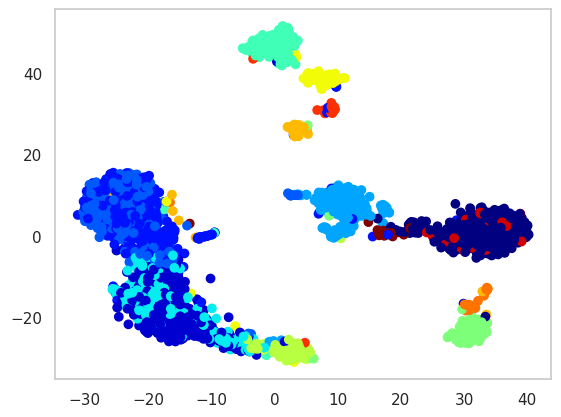

In [20]:
ds.plot_tsne()

In [46]:
np.unique(ds.inferred_domains)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [50]:
#(1328, 1215, 1)
ds.inferred_domains.shape

(1328, 1215, 1)

TypeError: 'SSAMDataset' object is not subscriptable

In [55]:
#770307
len(ds.inferred_domains[ds.inferred_domains != ds.inferred_domains_cells])

770307

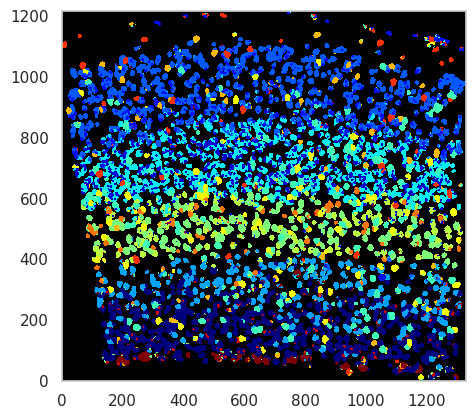

In [28]:
ds.plot_celltypes_map()

In [ ]:
from sklearn.manifold import TSNE
ds.tsne = TSNE(n_iter=n_iter, perplexity=perplexity, early_exaggeration=early_exaggeration, metric=metric, random_state=random_state, **tsne_kwargs).fit_transform(pcs[:, :pca_dims])
ds.zarr_group['tsne'] = ds.tsne

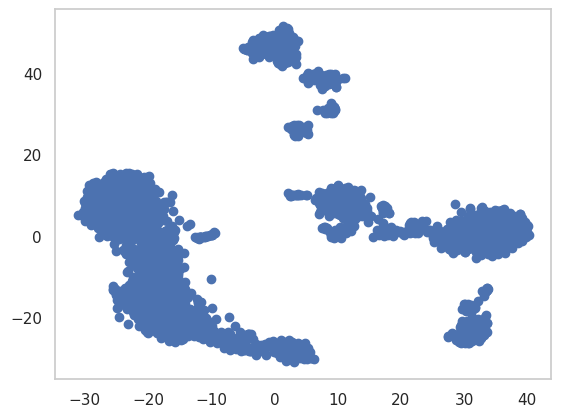

In [15]:
#colors
plt.scatter(ds.tsne[:, 0], ds.tsne[:, 1])

In [26]:
np.unique(ds.cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [45]:
import spatialdata as sd
regions = sd.ShapesModel.parse(
    xy,
    geometry=0,
    radius=cells.obsm["region_radius"],
    index=expression.obs['cell_id'].copy()
)


AttributeError: module 'spatialdata' has no attribute 'ShapesModel'

In [23]:
from scipy.sparse import csr_matrix
libraries = ['celltype_binned_centers', 'celltype_maps','filtered_celltype_maps','inferred_domains','inferred_domains_cells']

table_list = []
counts = csr_matrix(np.squeeze(ds.celltype_maps, 2), dtype=np.float32)
for lib in libraries:
    table = ad.AnnData(counts)
    table.obs["library_id"] = f"{lib}"
    table.uns[f"{lib}"] = getattr(ds, lib)
    table_list.append(table)
    print(table.uns)

table_set = ad.concat(
    table_list,
    keys=libraries,
)

OrderedDict([('celltype_binned_centers', array([[[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       ...,

       [[ 2],
        [14],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]]]))])
OrderedDict([('celltype_maps', array([[[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       [[-1],
        [-1],
        [-1],
        ...,
        [-1],
        [-1],
        [-1]],

       ...,

       [

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
table_set.uns

OrderedDict([('spatialdata_attrs',
              {'region': ['celltype_binned_centers',
                'celltype_maps',
                'filtered_celltype_maps',
                'inferred_domains',
                'inferred_domains_cells'],
               'region_key': 'library_id',
               'instance_key': 'cell_id'})])

In [12]:
import spatialdata as sd
table = sd.models.TableModel.parse(
    adata=table_set,
    region=[f"{lib}" for lib in libraries],
    region_key="library_id",
    instance_key="cell_id",
)

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/models/models.py:725: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[region_key]):
/tmp/ipykernel_1620812/2091612692.py:2: UserWarning: Converting `region_key: library_id` to categorical dtype.
  table = sd.models.TableModel.parse(


In [46]:
from scipy.sparse import csr_matrix
counts = csr_matrix(np.squeeze(ds.celltype_maps, 2), dtype=np.float32)

In [47]:
adata = ad.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 1328 × 1215

In [48]:
adata.X

<1328x1215 sparse matrix of type '<class 'numpy.float32'>'
	with 1431102 stored elements in Compressed Sparse Row format>

In [ ]:
adata

In [49]:
adata.obs['cell_id'] = ds.celltype_maps

In [50]:
adata.obs['library_id'] = ['celltype_binned_centers', 'celltype_maps','filtered_celltype_maps','inferred_domains','inferred_domains_cells']

ValueError: Length of values (5) does not match length of index (1328)

In [8]:
adata

NameError: name 'adata' is not defined

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


AttributeError: 'dict' object has no attribute 'uns'

In [21]:
np.squeeze(ds.celltype_maps, 2).shape

(1328, 1215)

In [11]:
ds.celltype_maps.shape

(1328, 1215, 1)

In [13]:
ds.filtered_celltype_maps.shape

(1328, 1215, 1)

In [14]:
ds.inferred_domains.shape

(1328, 1215, 1)

In [16]:
ds.inferred_domains_cells.shape

(1328, 1215, 1)

sdata_read = sd.read_zarr('ssam-osmfish-spatialdata.zarr')

#print(sdata['celltype_binned_counts'].data)
#print(sdata_read['celltype_binned_counts'].data)

from napari_spatialdata import Interactive
Interactive(sdata)